# Crop Disease Detection

#### This project is an approach to the development of crop disease detection model, based on leaf image classification, by the use of deep convolutional networks. The developed model is able to recognize 26 different types of crop diseases out of of 14 different plants.
#### Plants: 'Tomato',  'Apple',  'Blueberry',  'Grape', 'Peach', 'Corn', 'Cherry', 'Squash', 'Strawberry', 'Pepper', 'Orange', 'Potato', 'Raspberry', 'Soybean'

The dataset contains:
* 70295 training images
* 17572 testing images

Workflow:
1. Loading the images from the folder resizing them into 128 * 128 (256 * 256 takes time for processing) and coverting them to tensors
2. Building a validation dataset using 0.3% of the total dataset.
3. Loading the data using Batches
4. Trying various CNN architecture
  * Combination of Multilayer CNN with Linear Layers
  * VGG16 using Transfer Learning
  * Resnet34 using Transfer Learning
5. Selecting the device and loading the data into device i.e (GPU)
6. Training the model and evaluating the model on test data
7. Saving the Model

### Importing necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,TensorDataset
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models


In [3]:
from tqdm.notebook import tqdm

### Loading the Dataset

In [4]:
from google.colab import files
files.upload()  # Manually upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"namsrkive","key":"cd23fcc254035df35bf5a0506c80a509"}'}

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset


Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
new-plant-diseases-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
#extracting the dataset

import zipfile

with zipfile.ZipFile("new-plant-diseases-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("crop_disease_dataset")

print("Dataset extracted successfully!")


Dataset extracted successfully!


### Check the extracted dataset

In [8]:
project_name = 'crop-disease-detection'
data = "crop_disease_dataset"
print(os.listdir(data))  # List the extracted files/folders


['test', 'New Plant Diseases Dataset(Augmented)', 'new plant diseases dataset(augmented)']


In [9]:

# List main folders
print("Main Folders:", os.listdir(data))

# Check inside "New Plant Diseases Dataset(Augmented)"
augmented_path = os.path.join(data, "New Plant Diseases Dataset(Augmented)")
print("Inside Augmented Folder:", os.listdir(augmented_path))

# Check inside "new plant diseases dataset(augmented)"
augmented_path_lower = os.path.join(data, "new plant diseases dataset(augmented)")
print("Inside Lowercase Folder:", os.listdir(augmented_path_lower))


Main Folders: ['test', 'New Plant Diseases Dataset(Augmented)', 'new plant diseases dataset(augmented)']
Inside Augmented Folder: ['New Plant Diseases Dataset(Augmented)']
Inside Lowercase Folder: ['New Plant Diseases Dataset(Augmented)']


In [10]:
# First-level folders
print("Main Folders:", os.listdir(data))

# Check inside "New Plant Diseases Dataset(Augmented)"
augmented_path = os.path.join(data, "New Plant Diseases Dataset(Augmented)")
print("Inside Augmented Folder:", os.listdir(augmented_path))

# Go one level deeper inside "New Plant Diseases Dataset(Augmented)"
augmented_inner_path = os.path.join(augmented_path, "New Plant Diseases Dataset(Augmented)")
print("Inside Inner Augmented Folder:", os.listdir(augmented_inner_path))


Main Folders: ['test', 'New Plant Diseases Dataset(Augmented)', 'new plant diseases dataset(augmented)']
Inside Augmented Folder: ['New Plant Diseases Dataset(Augmented)']
Inside Inner Augmented Folder: ['valid', 'train']


In [11]:
train_dir = os.path.join(augmented_inner_path, "train")
valid_dir = os.path.join(augmented_inner_path, "valid")

print("Training Data Path:", train_dir)
print("Validation Data Path:", valid_dir)

# Check categories inside train folder
print("Categories in Train Folder:", os.listdir(train_dir))

# Check categories inside valid folder
print("Categories in Valid Folder:", os.listdir(valid_dir))


Training Data Path: crop_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
Validation Data Path: crop_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid
Categories in Train Folder: ['Apple___Apple_scab', 'Cherry_(including_sour)___healthy', 'Tomato___Early_blight', 'Tomato___Tomato_mosaic_virus', 'Tomato___Leaf_Mold', 'Tomato___Bacterial_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Peach___Bacterial_spot', 'Corn_(maize)___healthy', 'Tomato___Target_Spot', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Raspberry___healthy', 'Squash___Powdery_mildew', 'Cherry_(including_sour)___Powdery_mildew', 'Apple___healthy', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___healthy', 'Peach___healthy', 'Tomato___Late_blight', 'Apple___Black_rot', 'Orange___Haunglongbing_(Citrus_greening)', 'P

### Number of Unique Crops


In [12]:
# List all class folders inside train
cl = os.listdir(train_dir)

# Extract unique plant names
unique_plants = []
for i in cl:
    x = i.split('_')  # Splitting the folder name by '_'
    if x[0] not in unique_plants:
        unique_plants.append(x[0])

# Print results
print("Number of Unique Plants:", len(unique_plants))
print("Unique Plants:", unique_plants)


Number of Unique Plants: 14
Unique Plants: ['Apple', 'Cherry', 'Tomato', 'Peach', 'Corn', 'Grape', 'Raspberry', 'Squash', 'Orange', 'Potato', 'Blueberry', 'Soybean', 'Pepper,', 'Strawberry']


### Number of classes


In [13]:
from torchvision import datasets, transforms

# Apply basic image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for CNNs like VGG16, ResNet
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Get class names
num_classes = dataset.classes  # This will return a list of class folder names

print("Number of classes:", len(num_classes))
print("Classes:", num_classes)


Number of classes: 38
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_sp

### Loading Training and Test Dataset as Tensor

In [14]:
transform = transforms.Compose(
    [transforms.Resize(size = 128),
     transforms.ToTensor()])

In [15]:
# Load datasets
dataset = ImageFolder(train_dir, transform=transform)
test_ds = ImageFolder(valid_dir, transform=transform)

# Print dataset size
print("Number of training images:", len(dataset))
print("Number of testing images:", len(test_ds))


Number of training images: 70295
Number of testing images: 17572


In [16]:
image, label  = dataset[0]
print("Image shape:",image.shape)
print("Image Label: ",label)
print("Image Label: ",dataset.classes[label])
print(image)

Image shape: torch.Size([3, 128, 128])
Image Label:  0
Image Label:  Apple___Apple_scab
tensor([[[0.6588, 0.6549, 0.6510,  ..., 0.7373, 0.7333, 0.7176],
         [0.6627, 0.6588, 0.6510,  ..., 0.7373, 0.7373, 0.7294],
         [0.6667, 0.6667, 0.6667,  ..., 0.7333, 0.7294, 0.7294],
         ...,
         [0.4118, 0.4039, 0.3961,  ..., 0.4863, 0.4902, 0.4902],
         [0.4000, 0.4078, 0.4000,  ..., 0.4941, 0.4980, 0.4980],
         [0.4000, 0.4039, 0.4000,  ..., 0.4706, 0.4784, 0.4824]],

        [[0.6431, 0.6392, 0.6353,  ..., 0.7255, 0.7216, 0.7059],
         [0.6471, 0.6431, 0.6353,  ..., 0.7255, 0.7255, 0.7176],
         [0.6510, 0.6510, 0.6510,  ..., 0.7216, 0.7176, 0.7176],
         ...,
         [0.3725, 0.3647, 0.3569,  ..., 0.4235, 0.4275, 0.4275],
         [0.3608, 0.3686, 0.3608,  ..., 0.4314, 0.4353, 0.4353],
         [0.3608, 0.3647, 0.3608,  ..., 0.4078, 0.4157, 0.4196]],

        [[0.7725, 0.7686, 0.7647,  ..., 0.8392, 0.8353, 0.8196],
         [0.7765, 0.7725, 0.7647,  

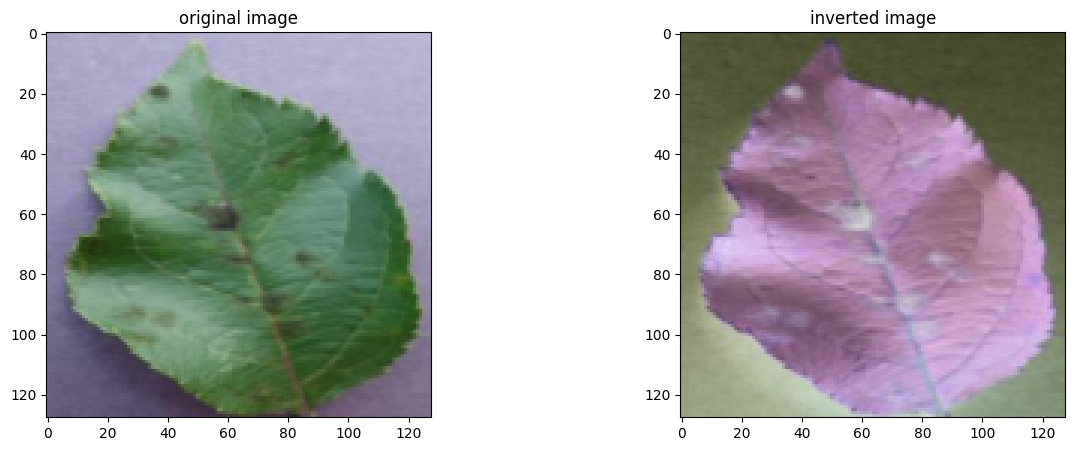

In [17]:
image, label  = dataset[0]
fig,(ax1,ax2) = plt.subplots(figsize=(15,5),nrows=1,ncols=2)
ax1.imshow(image.permute(1,2,0))
ax1.set_title("original image")
ax2.imshow(1-image.permute(1,2,0))
ax2.set_title("inverted image")
plt.show()

### Validation Dataset and Dataloader

In [18]:
random_seed = 42
torch.manual_seed(random_seed)

In [19]:
validation_split = 0.3
val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])


In [20]:
batch_size = 64

train_loader = DataLoader(train_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)

### Visualising a Batch of Images

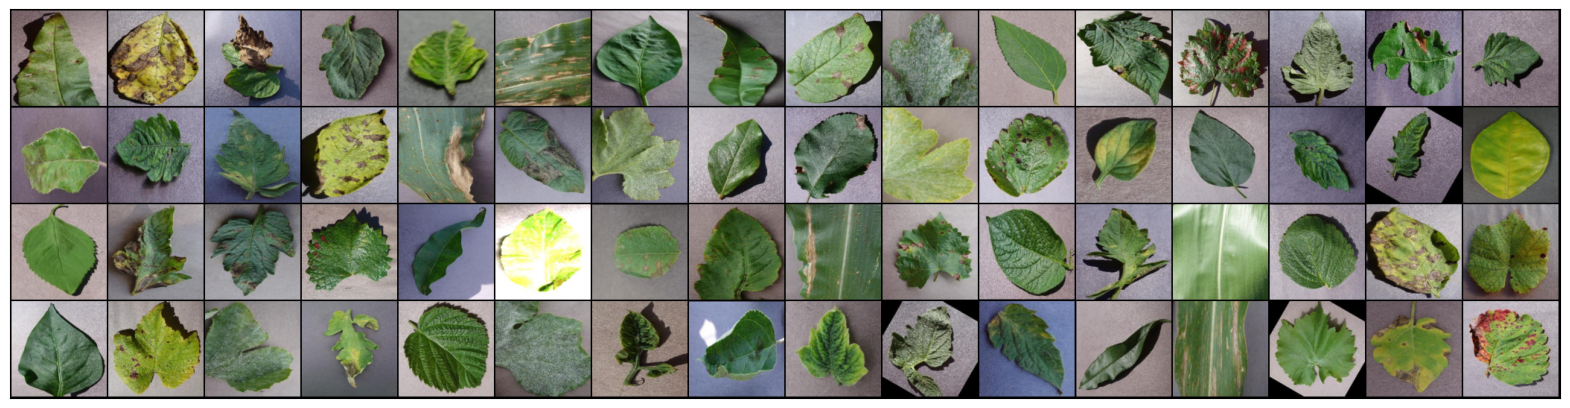

In [21]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

### Building The Model
#### Building a Base Image Classification Model

In [22]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):

  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_loss = [out['val_loss'] for out in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [out['val_acc'] for out in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

### Building a CNN model

In [23]:
class Crop_Disease_Model(ImageClassificationBase):

  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 64*64*64

        nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 128*32*32

        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 256*16*16

        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 512*8*8

        nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(512,1024,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 1024*4*4
        nn.AdaptiveAvgPool2d(1),

        nn.Flatten(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,38)
        )

  def forward(self,xb):
    out = self.network(xb)
    return out

### Building a VGG16 model using Transfer Learning


In [24]:
class Crop_Disease_Model1(ImageClassificationBase):

  def __init__(self):
    super().__init__()
    self.network = models.vgg16(pretrained=True)
    num_ftrs = self.network.classifier[-1].in_features
    self.network.classifier[-1] = nn.Linear(num_ftrs, 38)

  def forward(self,xb):
    out = self.network(xb)
    return out

### Building a resnet34 model using Transfer Learning


In [25]:
class Crop_Disease_Model2(ImageClassificationBase):

  def __init__(self):
    super().__init__()
    self.network = models.resnet34(pretrained=True)
    num_ftrs = self.network.fc.in_features
    self.network.fc = nn.Linear(num_ftrs, 38)

  def forward(self,xb):
    out = self.network(xb)
    return out

### Training and Evaluation


In [26]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [27]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

### Using GPU

In [28]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [29]:
device = get_default_device()
device

device(type='cuda')

In [30]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [31]:
model1 = to_device(Crop_Disease_Model(), device) # For CNN
model2 = to_device(Crop_Disease_Model1(), device) # For VGG16
model3 = to_device(Crop_Disease_Model2(), device) # For resnet

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
 

In [35]:
import torch
import torch.nn.functional as F

# Move models to the available device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {"Model 1 (CNN-Based)": model1, "Model 2 (VGG16)": model2, "Model 3 (ResNet34)": model3}

# Move all models to device
for name, model in models.items():
    model.to(device)
    model.eval()  # Set to evaluation mode

# Function to evaluate a model quickly
def quick_evaluate(model, loader, num_batches=50):
    correct, total, loss = 0, 0, 0.0
    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():  # Disable gradient calculation
        for i, (images, labels) in enumerate(loader):
            if i >= num_batches:  # Limit evaluation to a subset
                break

            images, labels = images.to(device), labels.to(device)

            with torch.cuda.amp.autocast():  # Speed up inference
                outputs = model(images)
                loss += criterion(outputs, labels).item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return loss / num_batches, correct / total  # Return average loss & accuracy

# Evaluate all models on a small validation subset
print("\nEvaluating Models on a Small Subset of Validation Data...")
results = {}

for name, model in models.items():
    val_loss, val_acc = quick_evaluate(model, val_loader, num_batches=50)  # Evaluate using 50 mini-batches
    results[name] = {"Validation Loss": val_loss, "Validation Accuracy": val_acc}
    print(f"{name}: Loss = {val_loss:.4f}, Accuracy = {val_acc:.4f}")

# Select the best model based on validation accuracy
best_model = max(results, key=lambda x: results[x]["Validation Accuracy"])
print(f"\nBest Model Selected: {best_model}")



Evaluating Models on a Small Subset of Validation Data...


<ipython-input-35-8e74006d6697>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Speed up inference


Model 1 (CNN-Based): Loss = 3.6381, Accuracy = 0.0306
Model 2 (VGG16): Loss = 3.5554, Accuracy = 0.0312
Model 3 (ResNet34): Loss = 4.0048, Accuracy = 0.0294

Best Model Selected: Model 2 (VGG16)


### Training the model

In [32]:
model = model2
model

Crop_Disease_Model1(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True

In [33]:
evaluate(model,val_loader)

{'val_loss': 3.6946797370910645, 'val_acc': 0.021732954308390617}

In [37]:
history = fit(10, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.0563, val_loss: 0.1271, val_acc: 0.9634


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0374, val_loss: 0.2132, val_acc: 0.9429


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0284, val_loss: 0.0897, val_acc: 0.9747


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0363, val_loss: 0.1038, val_acc: 0.9689


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0220, val_loss: 0.0988, val_acc: 0.9725


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.0280, val_loss: 0.0877, val_acc: 0.9745


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.0207, val_loss: 0.0879, val_acc: 0.9735


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0250, val_loss: 0.2191, val_acc: 0.9420


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0186, val_loss: 0.0575, val_acc: 0.9839


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0228, val_loss: 0.0327, val_acc: 0.9898


In [38]:
history += fit(5, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.0196, val_loss: 0.0487, val_acc: 0.9848


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0226, val_loss: 0.0405, val_acc: 0.9877


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0127, val_loss: 0.0718, val_acc: 0.9821


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0196, val_loss: 0.0551, val_acc: 0.9839


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0101, val_loss: 0.1211, val_acc: 0.9682


### Plotting the accuracy and losses

In [39]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [40]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

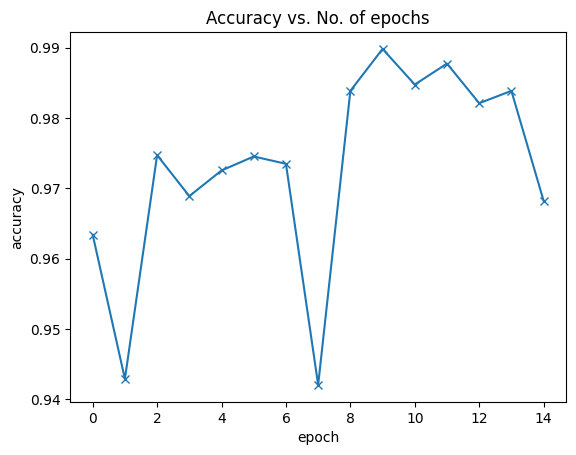

In [41]:
plot_accuracies(history)

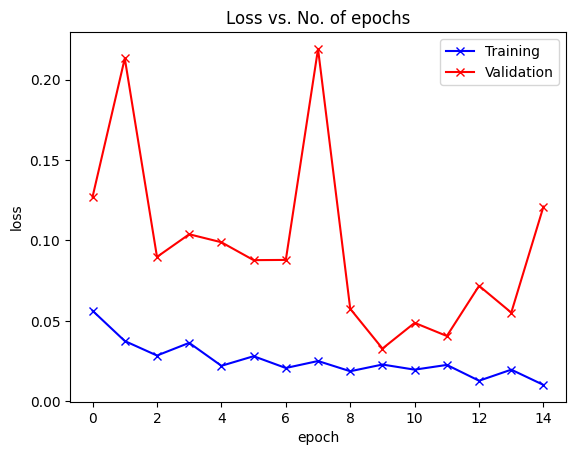

In [42]:
plot_losses(history)

In [45]:
evaluate(model,val_loader)


{'val_loss': 0.12088044732809067, 'val_acc': 0.9682765007019043}

### Evaluation and Prediction on Test Data

In [46]:
x = evaluate(model,test_loader)
x

{'val_loss': 0.12395621836185455, 'val_acc': 0.9692045450210571}

##### Accuracy of the model on test data is 96.9%


### Prediction on some single image of test data

In [47]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Label: Apple___Apple_scab , Predicted: Apple___Apple_scab


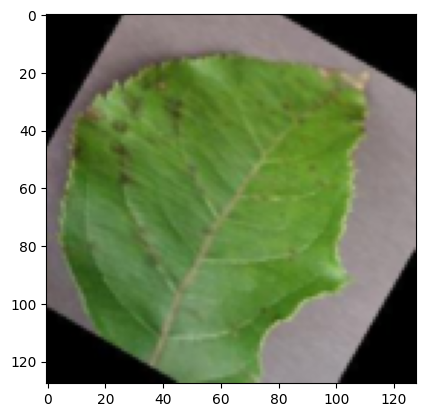

In [48]:
img, label = test_ds[25]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Apple___Black_rot , Predicted: Apple___Black_rot


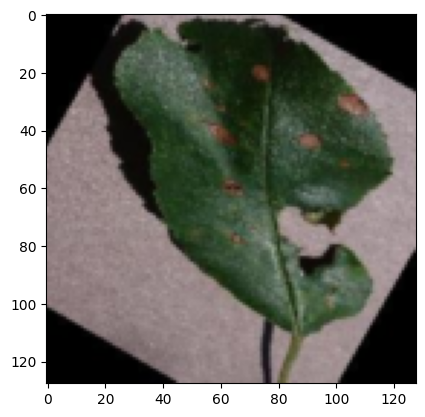

In [49]:
img, label = test_ds[978]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Cherry_(including_sour)___Powdery_mildew , Predicted: Cherry_(including_sour)___Powdery_mildew


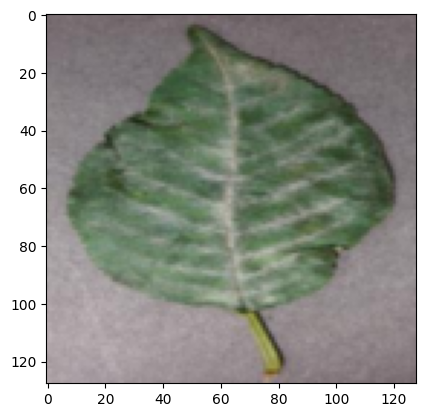

In [50]:
img, label = test_ds[2548]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

### Saving the Model

In [51]:
torch.save(model.state_dict(), 'crop_disease_model.pth')


## Loading and Testing the model

In [98]:
import torch
import torchvision.models as models

# Load the same model architecture (ResNet18, ResNet50, etc.)
model = models.resnet18(pretrained=False)  # Change if using a different model
num_classes = 38  # Update based on your dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Load the saved state_dict
checkpoint = torch.load('crop_disease_model.pth')

# Remove 'network.' prefix from keys
new_state_dict = {k.replace('network.', ''): v for k, v in checkpoint.items()}

# Load fixed state_dict
model.load_state_dict(new_state_dict, strict=False)

# Set model to evaluation mode
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [102]:
from PIL import Image
import torchvision.transforms as transforms

# Load and preprocess an image
image_path = "sample.webp"  # Change this to your test image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(input_tensor)
    predicted_idx = torch.argmax(output, dim=1).item()

# Class labels (update these as per your dataset)
class_labels = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
                'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy',
                'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight',
                'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
                'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy',
                'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight',
                'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew',
                'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight',
                'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
                'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
                'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

# Print the result
predicted_class = class_labels[predicted_idx]
print(f"Predicted Class: {predicted_class}")


Predicted Class: Corn_(maize)___healthy
